
# GEFCom2012 – Linear Regression with Multi‑lag Autoregressive Features (Station 3)

This notebook implements a **forecast + autoregressive** model for wind power prediction
at station **3** (`wp3`), using **multiple past lags** of the power time series:

\[
wp3(t-1),\; wp3(t-2),\;\dots,\; wp3(t-n)
\]

The number of lags \(n\) is controlled by a parameter `N_LAGS` (default: 3).

We:

1. Load & align the **ECMWF forecasts** and the **power output**.  
2. Build wind + time features.  
3. Add `N_LAGS` autoregressive features.  
4. Compare:
   - **Persistence baseline** (`wp3(t) = wp3(t-1)`),  
   - **LinearRegression** with forecast-only features,  
   - **LinearRegression** with forecast + multi-lag AR,  
   - **Polynomial (deg=3) + Ridge** with forecast + multi-lag AR.


In [43]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (8, 4)

# ---- Set number of lags here ----
N_LAGS = 3   # default, change this value to use more/less lags
print("Using N_LAGS =", N_LAGS)


Using N_LAGS = 3


## 1. Load and align data

In [44]:

DATA_DIR = Path("Wind")  # adapt this path if needed

train_path = DATA_DIR / "train.csv"
forecast_path = DATA_DIR / "windforecasts_wf3.csv"

print(train_path.resolve())
print(forecast_path.resolve())

# --- Load power data ---
df_power = pd.read_csv(train_path, delim_whitespace=True)
df_power["date"] = pd.to_datetime(df_power["date"], format="%Y%m%d%H")
df_power = df_power.set_index("date").sort_index()

# Focus on station 3
df_power = df_power[["wp3"]]

df_power.head()


C:\Users\henri\Desktop\PSC\Data-study\ForecastingData\Wind\train.csv
C:\Users\henri\Desktop\PSC\Data-study\ForecastingData\Wind\windforecasts_wf3.csv


C:\Users\henri\AppData\Local\Temp\ipykernel_2588\2551084748.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_power = pd.read_csv(train_path, delim_whitespace=True)


,wp3
date,
2009-07-01 00:00:00,0.494
2009-07-01 01:00:00,0.257
2009-07-01 02:00:00,0.178
2009-07-01 03:00:00,0.109
2009-07-01 04:00:00,0.079


In [45]:

# --- Load meteorological forecasts for wind farm 3 ---
df_fc = pd.read_csv(forecast_path)
df_fc["date"] = pd.to_datetime(df_fc["date"], format="%Y%m%d%H")

# Keep only short-term forecasts (1–12h ahead)
df_fc = df_fc[df_fc["hors"].between(1, 12)]

# Convert 'hors' into valid time (issue time + horizon)
df_fc["valid_time"] = df_fc["date"] + pd.to_timedelta(df_fc["hors"], unit="h")

# For each valid_time, keep the *shortest* horizon forecast
df_fc = df_fc.sort_values(["valid_time", "hors"])
df_fc_shortest = df_fc.groupby("valid_time").first().reset_index()

# Index by valid_time for alignment
df_fc_shortest = df_fc_shortest.set_index("valid_time").sort_index()

df_fc_shortest.head()


,date,hors,u,v,ws,wd
valid_time,,,,,,
2009-07-01 01:00:00,2009-07-01,1,3.51,-2.43,4.27,124.75
2009-07-01 02:00:00,2009-07-01,2,2.96,-2.12,3.65,125.63
2009-07-01 03:00:00,2009-07-01,3,2.47,-2.02,3.19,129.29
2009-07-01 04:00:00,2009-07-01,4,2.05,-2.06,2.90,135.14
2009-07-01 05:00:00,2009-07-01,5,1.72,-2.11,2.72,140.85


In [46]:

# --- Align forecasts with realized power ---
df = df_fc_shortest.join(df_power, how="inner")

print("Aligned shape:", df.shape)
print(df[["hors", "u", "v", "ws", "wd", "wp3"]].head())

# Drop any rows with missing core values
df = df.dropna(subset=["wp3", "u", "v", "ws"])
print("After dropping NAs:", df.shape)


Aligned shape: (13175, 7)
                     hors     u     v    ws      wd    wp3
2009-07-01 01:00:00     1  3.51 -2.43  4.27  124.75  0.257
2009-07-01 02:00:00     2  2.96 -2.12  3.65  125.63  0.178
2009-07-01 03:00:00     3  2.47 -2.02  3.19  129.29  0.109
2009-07-01 04:00:00     4  2.05 -2.06  2.90  135.14  0.079
2009-07-01 05:00:00     5  1.72 -2.11  2.72  140.85  0.099
After dropping NAs: (13175, 7)


### Quick look at the target

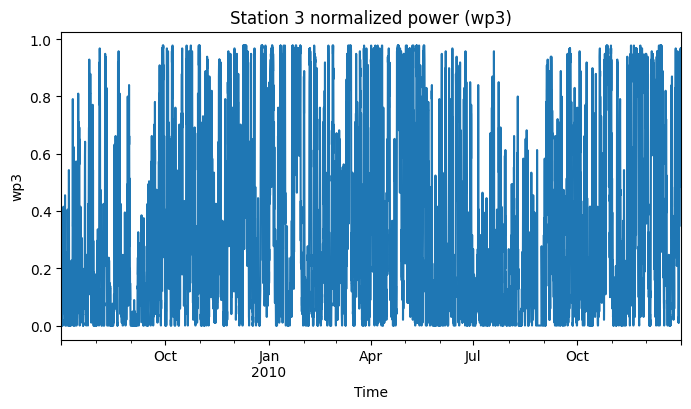

In [47]:

df["wp3"].plot(title="Station 3 normalized power (wp3)")
plt.xlabel("Time")
plt.ylabel("wp3")
plt.show()


## 2. Feature engineering (wind + time + multi-lag AR)

In [48]:

def add_time_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    idx = df.index

    df["hour"] = idx.hour
    df["dayofyear"] = idx.dayofyear

    # Cyclic encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

    return df

df_feat = add_time_features(df)

# ---- Add multi-lag autoregressive features: wp3(t-1)...wp3(t-N_LAGS) ----
for lag in range(1, N_LAGS + 1):
    df_feat[f"wp3_lag{lag}"] = df_feat["wp3"].shift(lag)

# Drop first N_LAGS rows where some lags are NaN
df_feat = df_feat.dropna(subset=[f"wp3_lag{lag}" for lag in range(1, N_LAGS + 1)])

cols_to_show = ["u", "v", "ws", "hors", "hour", "dayofyear"] + [f"wp3_lag{lag}" for lag in range(1, N_LAGS + 1)] + ["wp3"]
df_feat[cols_to_show].head()


,u,v,ws,hors,hour,dayofyear,wp3_lag1,wp3_lag2,wp3_lag3,wp3
2009-07-01 04:00:00,2.05,-2.06,2.90,4,4,182,0.109,0.178,0.257,0.079
2009-07-01 05:00:00,1.72,-2.11,2.72,5,5,182,0.079,0.109,0.178,0.099
2009-07-01 06:00:00,1.53,-2.07,2.57,6,6,182,0.099,0.079,0.109,0.069
2009-07-01 07:00:00,1.49,-1.86,2.38,7,7,182,0.069,0.099,0.079,0.000
2009-07-01 08:00:00,1.55,-1.62,2.24,8,8,182,0.000,0.069,0.099,0.000


In [49]:

target_col = "wp3"

forecast_features = ["u", "v", "ws", "hors", "hour_sin", "hour_cos", "doy_sin", "doy_cos"]
ar_features = [f"wp3_lag{lag}" for lag in range(1, N_LAGS + 1)]

# 1) Forecast-only features
X_all_forecast = df_feat[forecast_features].copy()

# 2) Forecast + multi-lag autoregressive features
X_all_ar = df_feat[forecast_features + ar_features].copy()

y_all = df_feat[target_col].values

print("Forecast-only X shape:", X_all_forecast.shape)
print("Forecast + multi-lag AR X shape:", X_all_ar.shape)


Forecast-only X shape: (13172, 8)
Forecast + multi-lag AR X shape: (13172, 11)


## 3. Train/validation split (by time)

In [50]:

n = len(df_feat)
split_idx = int(0.8 * n)

X_train_forecast = X_all_forecast.iloc[:split_idx]
X_valid_forecast = X_all_forecast.iloc[split_idx:]

X_train_ar = X_all_ar.iloc[:split_idx]
X_valid_ar = X_all_ar.iloc[split_idx:]

y_train = y_all[:split_idx]
y_valid = y_all[split_idx:]

print("Train size:", X_train_ar.shape, "Validation size:", X_valid_ar.shape)


Train size: (10537, 11) Validation size: (2635, 11)


## 4. Persistence baseline

In [51]:

# Persistence: predict wp3(t) = wp3(t-1)
y_all_series = df_feat[target_col]
y_persist = y_all_series.shift(1)

# Validation slice (same window as X_valid_ar)
y_persist_valid = y_persist.iloc[split_idx:]
y_valid_aligned = y_all_series.iloc[split_idx:]

mask = ~y_persist_valid.isna()
y_persist_valid = y_persist_valid[mask]
y_valid_aligned = y_valid_aligned[mask]

rmse_persist = root_mean_squared_error(y_valid_aligned, y_persist_valid)
print(f"Persistence RMSE on validation: {rmse_persist:.4f}")


Persistence RMSE on validation: 0.1017


## 5. Linear models

### 5.1 LinearRegression with forecast-only features

In [52]:

lin_forecast = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

lin_forecast.fit(X_train_forecast, y_train)
y_pred_forecast = lin_forecast.predict(X_valid_forecast)

rmse_forecast = root_mean_squared_error(y_valid, y_pred_forecast)
r2_forecast = r2_score(y_valid, y_pred_forecast)

print(f"Forecast-only LinearRegression – RMSE: {rmse_forecast:.4f}, R²: {r2_forecast:.4f}")


Forecast-only LinearRegression – RMSE: 0.1705, R²: 0.7333


### 5.2 LinearRegression with forecast + multi-lag AR

In [53]:

lin_ar = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

lin_ar.fit(X_train_ar, y_train)
y_pred_ar = lin_ar.predict(X_valid_ar)

rmse_ar = root_mean_squared_error(y_valid, y_pred_ar)
r2_ar = r2_score(y_valid, y_pred_ar)

print(f"Forecast + multi-lag AR LinearRegression – RMSE: {rmse_ar:.4f}, R²: {r2_ar:.4f}")


Forecast + multi-lag AR LinearRegression – RMSE: 0.0903, R²: 0.9252


### 5.3 Polynomial (deg=3) + Ridge with forecast + multi-lag AR

In [ ]:

poly_ridge_ar = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0]))
])

poly_ridge_ar.fit(X_train_ar, y_train)
y_pred_poly_ar = poly_ridge_ar.predict(X_valid_ar)

rmse_poly_ar = root_mean_squared_error(y_valid, y_pred_poly_ar)
r2_poly_ar = r2_score(y_valid, y_pred_poly_ar)

print(f"Poly (deg=3) + Ridge + multi-lag AR – RMSE: {rmse_poly_ar:.4f}, R²: {r2_poly_ar:.4f}")
print("Selected alpha:", poly_ridge_ar.named_steps["ridge"].alpha_)


Poly (deg=3) + Ridge + multi-lag AR – RMSE: 0.0878, R²: 0.9293
Selected alpha: 1.0


## 6. Diagnostics – impact of multi-lag AR features

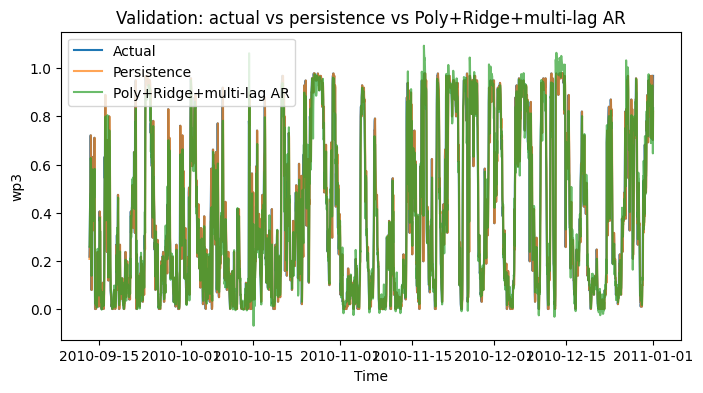

In [55]:

plt.plot(df_feat.index[split_idx:], y_valid, label="Actual")
plt.plot(df_feat.index[split_idx:], y_persist_valid, label="Persistence", alpha=0.7)
plt.plot(df_feat.index[split_idx:], y_pred_poly_ar, label="Poly+Ridge+multi-lag AR", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("wp3")
plt.title("Validation: actual vs persistence vs Poly+Ridge+multi-lag AR")
plt.legend()
plt.show()


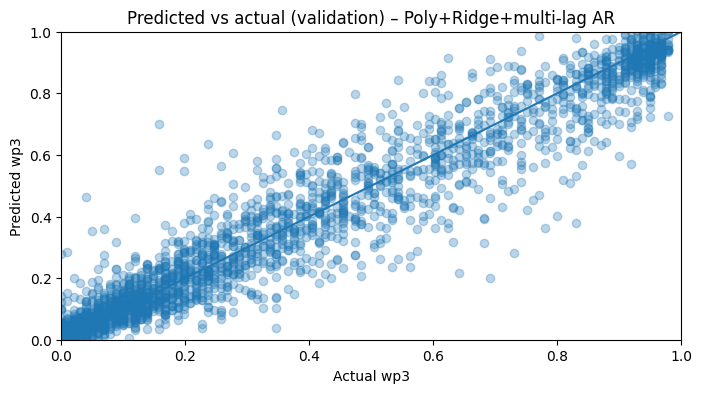

In [56]:

plt.scatter(y_valid, y_pred_poly_ar, alpha=0.3)
lims = [0, 1]
plt.plot(lims, lims)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual wp3")
plt.ylabel("Predicted wp3")
plt.title("Predicted vs actual (validation) – Poly+Ridge+multi-lag AR")
plt.show()
